# Part A

## (1)

In [1]:
import numpy as np
import copy

In [2]:
class Factor:
    def __init__(self, vars, probs):
        self.header = np.array(sorted(vars))
        if type(probs) is np.ndarray:
            self.table = probs
        else:
            order = np.argsort(vars)
            probs.sort(key=lambda x: tuple(x[i] for i in order))
            self.table = np.array([p[-1] for p in probs])
            self.table = self.table.reshape((2, ) * len(vars))

    def restrict(self, var, val):
        if var not in self.header:
            return

        index = 1 if val else 0
        axis = np.where(self.header == var)[0][0]
        self.header = np.delete(self.header, axis)
        self.table = np.take(self.table, index, axis=axis)

    def __mul__(self, other):
        new_header = np.array(sorted(np.union1d(self.header, other.header)))
        a = self.table.copy()
        b = other.table.copy()

        for index, var in enumerate(new_header):
            if var not in self.header:
                a = np.expand_dims(a, axis=index)
            if var not in other.header:
                b = np.expand_dims(b, axis=index)

        new_table = a * b
        return Factor(new_header, new_table)

    def sumout(self, var):
        if var not in self.header:
            return

        axis = np.where(self.header == var)[0][0]
        self.header = np.delete(self.header, axis)
        self.table = np.sum(self.table, axis=axis)

    def normalize(self):
        self.table /= np.sum(self.table)

    def possibility(self, vars):
        if len(vars) != len(self.header):
            raise Exception("Invalid query size.")

        index = []
        for var in self.header:
            if var in vars:
                index.append(1)
            elif "not " + var in vars:
                index.append(0)
            else:
                raise Exception("Invalid query.")

        return self.table.item(tuple(index))

    def __copy__(self):
        return Factor(self.header, self.table)
    
    def __str__(self):
        table_format = '{:<15}' * (len(self.header) + 1)
        result = [table_format.format(*(self.header.tolist() + ['probability']))]
        for index, value in np.ndenumerate(self.table):
            row = ['True' if boolean > 0 else 'False' for boolean in index]
            result.append(table_format.format(*(row + [value])))

        return '\n'.join(result) + '\n'

In [3]:
def inference(factors, query, hidden_list, evidence_list, print_step=True):
    def step_printer(factor_list):
        for factor in factor_list:
            print(factor)

    factor_list = [copy.copy(factor) for factor in factors]

    if print_step:
        print('Initialized factors:')
        step_printer(factor_list)

    for factor in factor_list:
        for evidence, value in evidence_list.items():
            factor.restrict(evidence, value)
    if print_step:
        print('After restriction:')
        step_printer(factor_list)

    product = np.prod(factor_list)

    if print_step:
        print('After production:')
        step_printer([product])

    for hidden in hidden_list:
        product.sumout(hidden)

    if print_step:
        print('After summing out:')
        step_printer([product])

    product.normalize()

    if print_step:
        print('After normalization:')
        step_printer([product])

    if set(query) == set(product.header):
        return product
    else:
        raise Exception("Invalid query size.")

## (2)

In [4]:
# Fraud | Trav
f1 = Factor(['Fraud', 'Trav'],
            [(0, 0, 1 - 0.004),
             (0, 1, 1 - 0.01),
             (1, 0, 0.004),
             (1, 1, 0.01)])

# Trav
f2 = Factor(['Trav'],
            [(0, 1 - 0.05),
             (1, 0.05)])

# FP | Fraud, Trav
f3 = Factor(['FP', 'Fraud', 'Trav'],
            [(0, 0, 0, 1 - 0.01),
             (0, 0, 1, 1 - 0.9),
             (0, 1, 0, 1 - 0.1),
             (0, 1, 1, 1 - 0.9),
             (1, 0, 0, 0.01),
             (1, 0, 1, 0.9),
             (1, 1, 0, 0.1),
             (1, 1, 1, 0.9)])

# OC
f4 = Factor(['OC'],
            [(0, 1 - 0.6),
             (1, 0.6)])

# IP | OC, Fraud
f5 = Factor(['IP', 'OC', 'Fraud'],
            [(0, 0, 0, 1 - 0.001),
             (0, 0, 1, 1 - 0.011),
             (0, 1, 0, 1 - 0.01),
             (0, 1, 1, 1 - 0.02),
             (1, 0, 0, 0.001),
             (1, 0, 1, 0.011),
             (1, 1, 0, 0.01),
             (1, 1, 1, 0.02)])

# CRP | OC
f6 = Factor(['CRP', 'OC'],
            [(0, 0, 1 - 0.001),
             (0, 1, 1 - 0.1),
             (1, 0, 0.001),
             (1, 1, 0.1)])

### a)

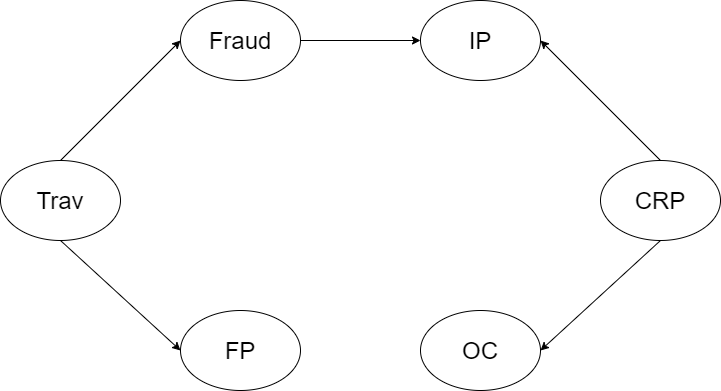

In [5]:
from IPython.display import Image
Image('./A3Q2a.png')

### b)

In [6]:
factor_list = [f1, f2, f3, f4, f5, f6]
ans = inference(factor_list, ['Fraud'], ['Trav', 'FP', 'IP', 'OC', 'CRP'], dict())
print("P(Fraud) = " + str(ans.possibility(['Fraud'])))

ans = inference(factor_list, ['Fraud'], ['Trav', 'OC'], {'FP': True, 'IP': False, 'CRP': True})
print("P(Fraud | FP, ~IP, CRP) = " + str(ans.possibility(['Fraud'])))

Initialized factors:
Fraud          Trav           probability    
False          False          0.996          
False          True           0.99           
True           False          0.004          
True           True           0.01           

Trav           probability    
False          0.95           
True           0.05           

FP             Fraud          Trav           probability    
False          False          False          0.99           
False          False          True           0.09999999999999998
False          True           False          0.9            
False          True           True           0.09999999999999998
True           False          False          0.01           
True           False          True           0.9            
True           True           False          0.1            
True           True           True           0.9            

OC             probability    
False          0.4            
True           0.6            

Fr

### c)

In [7]:
ans = inference(factor_list, ['Fraud'], ['OC'], {'FP': True, 'IP': False, 'CRP': True, 'Trav': True})
print("P(Fraud | FP, ~IP, CRP, Trav) = " + str(ans.possibility(['Fraud'])))

Initialized factors:
Fraud          Trav           probability    
False          False          0.996          
False          True           0.99           
True           False          0.004          
True           True           0.01           

Trav           probability    
False          0.95           
True           0.05           

FP             Fraud          Trav           probability    
False          False          False          0.99           
False          False          True           0.09999999999999998
False          True           False          0.9            
False          True           True           0.09999999999999998
True           False          False          0.01           
True           False          True           0.9            
True           True           False          0.1            
True           True           True           0.9            

OC             probability    
False          0.4            
True           0.6            

Fr

### d)

In [8]:
ans = inference(factor_list, ['Fraud'], ['Trav', 'FP', 'OC', 'CRP'], {'IP': True})
print("P(Fraud | IP) = " + str(ans.possibility(['Fraud'])))

cond_vars = ['FP', 'CRP']
for enum in range(2 ** 2):
    bin = "{0:02b}".format(enum)
    cond = {var: dig == '1' for var, dig in zip(cond_vars, bin)}
    cond['IP'] = True
    ans = inference(factor_list, ['Fraud'], ['Trav', 'OC'], cond)

    cond_to_print = [var if dig == '1' else '~' + var for var, dig in zip(cond_vars, bin)]
    print('P(Fraud | ' + ', '.join(cond_to_print) + ') = ' + str(ans.possibility(['Fraud'])))

Initialized factors:
Fraud          Trav           probability    
False          False          0.996          
False          True           0.99           
True           False          0.004          
True           True           0.01           

Trav           probability    
False          0.95           
True           0.05           

FP             Fraud          Trav           probability    
False          False          False          0.99           
False          False          True           0.09999999999999998
False          True           False          0.9            
False          True           True           0.09999999999999998
True           False          False          0.01           
True           False          True           0.9            
True           True           False          0.1            
True           True           True           0.9            

OC             probability    
False          0.4            
True           0.6            

Fr

As is illustrated above, we are supposed to satisfy conditions ~FP, CRP to get the minimal probability. Thus, I should use domestic currency for the payment after making a computer related purchase. This will help reduce the probability from 1.094% to 0.734%, which is approximately 0.36%.

# Part B

In [9]:
import math

In [10]:
train_data_path = './dataset/trainData.txt'
train_label_path = './dataset/trainLabel.txt'
test_data_path = './dataset/testData.txt'
test_label_path = './dataset/testLabel.txt'
words_path = './dataset/words.txt'

# Labels must start from 1 since we will minus 1 when storing
actual_labels = [1, 2]

labels = [label - 1 for label in actual_labels]

In [11]:
class Document:
    def __init__(self, label, doc_id=0):
        self.id = doc_id
        self.label = label - 1
        # Set labels to start from 0, it makes no difference
        self.word_list = set()

    def __contains__(self, word):
        return word in self.word_list

    def add_word(self, word):
        self.word_list.add(word - 1)
        # We store word - 1 here so that we only need to consider
        # the index issue when mapping word id to its word


def load_train_data():
    return load_data(train_data_path, train_label_path)


def load_test_data():
    return load_data(test_data_path, test_label_path)


def load_data(data_path, label_path):
    docs = []
    with open(label_path, 'r', encoding='utf-8') as file:
        for index, line in enumerate(file):
            doc_id = index + 1
            label = int(line.strip())
            docs.append(Document(label, doc_id))

    with open(data_path, 'r', encoding='utf-8') as file:
        for line in file.readlines():
            [doc_id, word_id] = list(map(int, line.strip().split(' ')))
            docs[doc_id - 1].add_word(word_id)

    return docs


def load_words(filename=words_path):
    word_map = dict()

    with open(filename, 'r', encoding='utf-8') as file:
        for index, word in enumerate(file):
            # Similar to above, we minus 1 for the word id
            word_map[index] = word.strip()

    return word_map

In [12]:
class NaiveBayes:
    def __init__(self, word_map, labels):
        self.word_set = set(word_map)
        self.poss_labels = labels

    def fit(self, docs):
        num_words = len(self.word_set)
        num_label = len(self.poss_labels)
        stat = np.zeros((num_words, num_label))

        for document in docs:
            for word in document.word_list:
                stat[word][document.label] += 1

        label_sum = np.sum(stat, axis=1, keepdims=True)
        word_sum = np.sum(stat, axis=0, keepdims=True)
        # prob_given_label[word][label] stores the value of Pr(word | label)
        self.prob_given_label = (stat + 1) / (label_sum + num_words)
        # prob_given_word[label][word] stores the value of Pr(label | word)
        self.prob_given_word = np.transpose((stat + 1) / (word_sum + num_label))

    def predict(self, word_list):
        p = dict()
        for label in self.poss_labels:
            p[label] = 1
            for word in self.word_set:
                if word in word_list:
                    p[label] *= self.prob_given_label[word][label]
                else:
                    p[label] *= 1 - self.prob_given_label[word][label]

        return max(p, key=p.get)

    def __diff(self, word, label1, label2):
        return abs(math.log(self.prob_given_label[word][label1]) -
                   math.log(self.prob_given_label[word][label2]))

    def discriminative(self, n, label1=0, label2=1):
        rank = {word: self.__diff(word, label1, label2) for word in self.word_set}
        return sorted(rank, key=rank.get, reverse=True)[: n]

In [13]:
def test(model, data):
    correct, incorrect = 0, 0
    for doc in data:
        label = doc.label
        pred = model.predict(doc)
        if pred == label:
            correct += 1
        else:
            incorrect += 1

    return correct / (correct + incorrect)


train_data = load_train_data()
test_data = load_test_data()
word_map = load_words()

nb = NaiveBayes(word_map, labels)
nb.fit(train_data)
disc_words = nb.discriminative(10)
print("Top 10 discriminative words:")
print([word_map[word] for word in disc_words])

print("Training accuracy: " + str(test(nb, train_data)))
print("Testing accuracy: " + str(test(nb, test_data)))

Top 10 discriminative words:
['christian', 'religion', 'atheism', 'books', 'christians', 'library', 'religious', 'libraries', 'novel', 'beliefs']
Training accuracy: 0.908
Testing accuracy: 0.7286666666666667


The assumption that all word features are independent is not reasonable. One example is shown above in the most discriminative 10 words that the same words may appear in an article in different forms, say 'christian' and 'christians'.

To take into account dependencies between words, we would better apply a stemming algorithm first, which will reduce all words to their roots so that different forms of the same words will be counted as only one.